In [1]:
import math
import numpy as np
import h5py as hpy
from matplotlib import pyplot as plt
from scipy import ndimage
from PIL import Image
import tensorflow as tf

%matplotlib inline
np.random.seed(1)

In [15]:
file=hpy.File('train_signs.h5','r')
X_train_orig=tf.data.Dataset.from_tensor_slices(file['train_set_x'])
Y_train_orig=tf.data.Dataset.from_tensor_slices(file['train_set_y'])

file=hpy.File('test_signs.h5','r')
X_test_orig=tf.data.Dataset.from_tensor_slices(file['test_set_x'])
Y_test_orig=tf.data.Dataset.from_tensor_slices(file['test_set_y'])


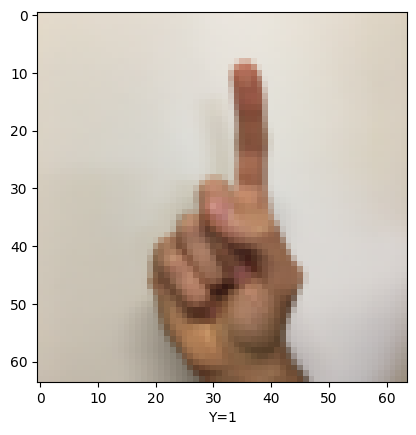

In [62]:
index=25
dataset=tf.data.Dataset.zip(X_train_orig,Y_train_orig)
for (datas_X,datas_Y) in dataset:
    index-=1
    if index==0:
        plt.imshow(datas_X)
        plt.xlabel(f"Y={datas_Y.numpy()}")
        break

Normalize the dataset, also need of one hot encoding maybe

In [72]:
def normalize(image):
    image=tf.cast(image,dtype=tf.float32)/255
    return image

X_train_norm=X_train_orig.map(normalize)
X_test_norm=X_test_orig.map(normalize)


In [90]:
def one_hot(label,depth):
    label=tf.one_hot(indices=label,depth=depth)
    return label

Y_test_one=Y_test_orig.map(lambda Y_test_orig:one_hot(Y_test_orig,6))
Y_train_one=Y_train_orig.map(lambda Y_train_orig:one_hot(Y_train_orig,6))


TensorFlow requires that uou create placeholder for image data

def create_placeholders(n_H0,n_W0,n_C0,n_y)

In [126]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    X=tf.keras.Input(shape=[n_H0,n_W0,n_C0])
    Y=tf.keras.Input(shape=(n_y))
    return X,Y

In [99]:
X,Y=create_placeholders(64,64,3,6)
print(X)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 64, 64, 3), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'")


Initialize parameters for filters

In [138]:
def initialize_parameters():
    initializer=tf.initializers.glorot_normal(seed=0)
    
    W1=tf.Variable(initial_value=initializer(shape=[4,4,3,8]))
    W2=tf.Variable(initial_value=initializer(shape=[2,2,8,16]))

    parameters={'W1':W1,
                'W2':W2}
    
    return parameters

In [139]:
parameters=initialize_parameters()
print(parameters['W2'].shape)

(2, 2, 8, 16)


In [164]:
def convNet(input_shape):
    
    input_img=tf.keras.Input(shape=input_shape)
    
    # W1=parameters['W1']
    # W2=parameters['W2']

    Z1=tf.keras.layers.Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding="SAME")(input_img)
    A1=tf.keras.layers.ReLU()(Z1)
    # P1=tf.nn.max_pool(input=A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    P1 = tf.keras.layers.MaxPool2D(pool_size=(8,8), strides=(8, 8), padding='same')(A1)
    # Z2=tf.nn.conv2d(input=P1,filters=W2,strides=[1,1,1,1],padding='SAME')
    Z2=tf.keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=(1,1),padding="SAME")(P1)
    # A2=tf.nn.relu(Z2)
    A2=tf.keras.layers.ReLU()(Z2)
    # P2=tf.nn.max_pool(input=A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=(4, 4), padding='same')(A2)
    F=tf.keras.layers.Flatten()(P2)
    Z3=tf.keras.layers.Dense(units=6,activation='linear')(F)

    model=tf.keras.Model(inputs=input_img,outputs=Z3)
    return model
    return Z3

In [170]:
conv_model=convNet((64,64,3))
conv_model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
conv_model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 8)         392       
                                                                 
 re_lu_20 (ReLU)             (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 8, 8, 8)           0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 8, 8, 16)          528       
                                                                 
 re_lu_21 (ReLU)             (None, 8, 8, 16)          0         
                                                          

In [168]:
dataset=tf.data.Dataset.zip(X_train_norm,Y_train_one)
mini_bactches=dataset.batch(64)
print(mini_bactches.cardinality())
history=conv_model.fit(mini_bactches,epochs=100)

tf.Tensor(17, shape=(), dtype=int64)
Epoch 1/100
17/17 [==============================] - 1s 29ms/step - loss: 1.7934 - accuracy: 0.1907
Epoch 2/100
17/17 [==============================] - 0s 28ms/step - loss: 1.7860 - accuracy: 0.2120
Epoch 3/100
17/17 [==============================] - 0s 29ms/step - loss: 1.7823 - accuracy: 0.2491
Epoch 4/100
17/17 [==============================] - 0s 28ms/step - loss: 1.7795 - accuracy: 0.2426
Epoch 5/100
17/17 [==============================] - 0s 29ms/step - loss: 1.7750 - accuracy: 0.2676
Epoch 6/100
17/17 [==============================] - 0s 29ms/step - loss: 1.7704 - accuracy: 0.2991
Epoch 7/100
17/17 [==============================] - 0s 29ms/step - loss: 1.7637 - accuracy: 0.3176
Epoch 8/100
17/17 [==============================] - 0s 28ms/step - loss: 1.7538 - accuracy: 0.3481
Epoch 9/100
17/17 [==============================] - 1s 30ms/step - loss: 1.7407 - accuracy: 0.3778
Epoch 10/100
17/17 [==============================] - 0s 29ms/s